In [50]:
# pip install pymoo

In [51]:
# pip install pygmo

In [52]:
from implementation import nsga2
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.problems import get_problem
from pymoo.optimize import minimize
from pymoo.visualization.scatter import Scatter
# from pygmo import hypervolume
import pygmo as pg
from matplotlib import pyplot as plt

In [82]:
import numpy as np

def ZDT1(x):
    n = len(x)  # Number of decision variables
    f1 = x[0]  # Objective 1 is just the first variable
    g = 1 + 9 * np.sum(x[1:]) / (n - 1)
    f2 = g * (1 - np.sqrt(f1 / g))  # Objective 2 formula
    return f1, f2


def ZDT2(x):
    n = len(x)  # Number of decision variables
    f1 = x[0]  # Objective 1 is just the first variable
    g = 1 + 9 * np.sum(x[1:]) / (n - 1)
    f2 = g * (1 - (f1 / g) ** 2)  # Objective 2 formula
    return f1, f2

def ZDT3(x):
    n = len(x)  # Number of decision variables
    f1 = x[0]  # Objective 1 is just the first variable
    g = 1 + 9 * np.sum(x[1:]) / (n - 1)  # g function
    h =  1 - np.sqrt(f1 / g) - (f1 / g) * np.sin(10 * np.pi * f1) # h function
    f2 = g * h  # Objective 2 formula
    return f1, f2

#TODO za zdt4 izmeniti crossover i mutation (jos nesto?)
def ZDT4(x):
    n = len(x)  # Number of decision variables
    f1 = x[0]  # Objective 1 is just the first variable
    g = 1 + 10 * (n - 1) + np.sum(x[1:]**2 - 10 * np.cos(4 * np.pi * x[1:]))  # g function
    h =  1 - np.sqrt(f1 / g) # h function
    f2 = g * h  # Objective 2 formula
    return f1, f2

def ZDT6(x):
    n = len(x)  # Number of decision variables
    f1 = 1 - np.exp(-4 * x[0]) * np.sin(6 * np.pi * x[0])**6 # Objective 1 formula
    g = 1 + 9 * (np.sum(x[1:]) / (n - 1))**0.25  # g function
    h =  1 - (f1 / g)**2 # h function
    f2 = g * h  # Objective 2 formula
    return f1, f2


In [55]:
def calc_hv_nsga2(population_size, num_variables, num_generations, tournament_size,
                  mutation_prob, elitism_size, objective_function, reference_point):
    """
    Calculate hypervolumen of my implementation of nsga2 algorithm
    """
    final_pareto_front = nsga2(population_size=population_size, 
                         num_variables=num_variables,
                         num_generations=num_generations, 
                         tournament_size=tournament_size,
                         mutation_prob=mutation_prob, 
                         elitism_size=elitism_size,
                         objective_function=objective_function)
    pareto_front = [(ind.fitness[0], ind.fitness[1]) for ind in final_pareto_front]
    pareto_front_array = np.array(pareto_front)
    hv = pg.hypervolume(pareto_front_array)
    return hv.compute(reference_point)

In [57]:
def calc_hv_pymoo(population_size, num_generations, problem_name, reference_point):
    
    problem = get_problem(problem_name)
    algorithm = NSGA2(pop_size=population_size)
    res = minimize(problem, 
                   algorithm, 
                   ('n_gen', num_generations), 
                   seed=1, 
                   verbose=False)
    hv = pg.hypervolume(res.F)
    return hv.compute(reference_point)

In [81]:
hv_nsga2 = calc_hv_nsga2(population_size = 100, num_variables = 30, 
                         num_generations = 200, tournament_size = 3, 
                         mutation_prob = 0.1, elitism_size = 10, objective_function=ZDT2, 
                         reference_point=[1.5,1.5])
hv_pymoo = calc_hv_pymoo(100,200, "zdt2", [1.5,1.5])

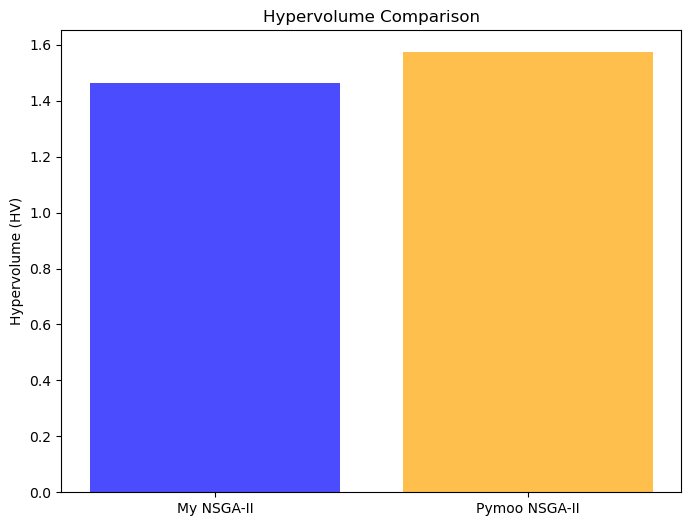

In [65]:
labels = ['My NSGA-II', 'Pymoo NSGA-II']
values = [hv_nsga2, hv_pymoo]

plt.figure(figsize=(8, 6))
plt.bar(labels, values, color=['blue', 'orange'], alpha=0.7)
plt.ylabel('Hypervolume (HV)')
plt.title('Hypervolume Comparison')
plt.show()

In [67]:
def calc_ms_nsga2(population_size, num_variables, num_generations, tournament_size,
                   mutation_prob, elitism_size, objective_function):
    final_pareto_front = nsga2(population_size=population_size, 
                                num_variables=num_variables,
                                num_generations=num_generations, 
                                tournament_size=tournament_size,
                                mutation_prob=mutation_prob, 
                                elitism_size=elitism_size,
                                objective_function=objective_function)
    pareto_front = [(ind.fitness[0], ind.fitness[1]) for ind in final_pareto_front]
    pareto_front = np.array(pareto_front)
    pareto_front_sorted = pareto_front[np.argsort(pareto_front[:, 0])]
    distances = np.linalg.norm(np.diff(pareto_front_sorted, axis=0), axis=1)
    ms = np.sum(distances) / len(distances)
    return ms

In [76]:
def calc_ms_pymoo(population_size, num_generations, problem_name):
    problem = get_problem(problem_name)
    algorithm = NSGA2(pop_size=population_size)
    res = minimize(problem, 
                   algorithm, 
                   ('n_gen', num_generations), 
                   seed=1, 
                   verbose=False)
    pareto_front = res.F
    pareto_front = np.array(pareto_front)
    pareto_front_sorted = pareto_front[np.argsort(pareto_front[:, 0])]
    distances = np.linalg.norm(np.diff(pareto_front_sorted, axis=0), axis=1)
    ms = np.sum(distances) / len(distances) 
    return ms
    

In [79]:
ms_nsga2 = calc_ms_nsga2(population_size = 100, num_variables = 30, 
              num_generations = 200, tournament_size = 3,
              mutation_prob = 0.1, elitism_size = 10, objective_function=ZDT2)
ms_pymoo = calc_ms_pymoo(population_size=100, num_generations= 200, problem_name="zdt2")

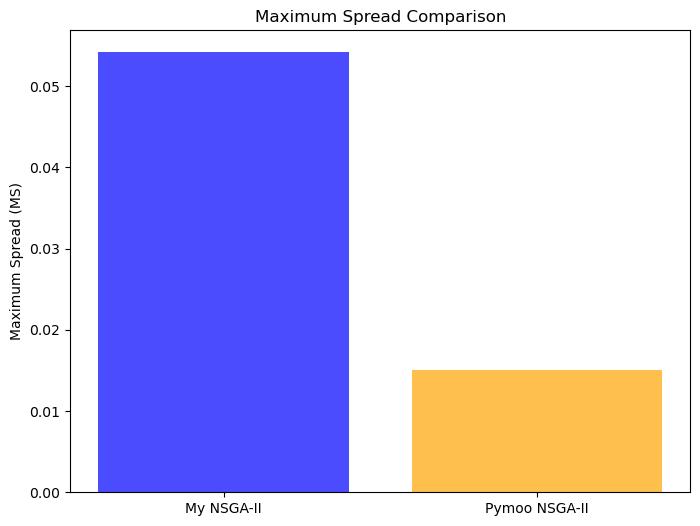

In [80]:
labels = ['My NSGA-II', 'Pymoo NSGA-II']
values = [ms_nsga2, ms_pymoo]

plt.figure(figsize=(8, 6))
plt.bar(labels, values, color=['blue', 'orange'], alpha=0.7)
plt.ylabel('Maximum Spread (MS)')
plt.title('Maximum Spread Comparison')
plt.show()